author: Xue (Lily) Yang, git@lilyportfolio

# Importing Libraries



In [ ]:
#These libraries help to interact with the operating system and the runtime environment respectively
import os
import sys

#Model/Training related libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
import csv
import pandas as pd
import random
from matplotlib import pyplot as plt

#Dataloader libraries
from torch.utils.data import DataLoader, Dataset

In [ ]:
if __name__ == '__main__':
    #GPU Check
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    num_workers = 8 if cuda else 0
    print('Cuda = ', cuda, 'num of workers =', num_workers, "system version = ", sys.version)

Cuda =  True num of workers = 8 system version =  3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]


In [ ]:
torch.cuda.empty_cache()
random.seed(1234)

In [ ]:
!nvidia-smi

Sat Dec  4 23:05:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8    12W / 151W |    810MiB /  8097MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Tuning args

In [ ]:
tuning_args = {
    'batch_size': 512,
    'num_epochs': 100
    }

# Setting up Data

## 1. Load Data and Data Preprocessing

### Parse data points and split

In [ ]:
def parse_data(datadir):
    data_list = []
    for root, directories, filenames in os.walk(datadir):
        for filename in filenames:
            if filename.endswith('.npy'):
                filei = os.path.join(root, filename)
                data_list.append(filei)
    return data_list

In [ ]:
data_path = "psam_pusa/"
data_list = parse_data(data_path)
lengths = [int(len(data_list)*0.7), int(len(data_list)*0.2), int(len(data_list)*0.1)]
print(lengths)
random.shuffle(data_list)

[1161165, 331761, 165880]


In [ ]:
train_list = data_list[:lengths[0]]
val_list = data_list[lengths[0]:lengths[0]+lengths[1]]
test_list = data_list[-lengths[2]:]

### Data Removal

In [ ]:
import csv
colnames = pd.read_csv("psam_pusa_colnames.csv") 

#### Remove income related columns

In [ ]:
numeric_indices = colnames[~colnames.iloc[:, 1].str.contains('PINCP|INTP|OIP|PAP|RETP|SEMP|SSIP|SSP|WAGP|PERNP', regex=True)]

#### >60% null values

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('GCM_|DRAT_|SFN_|SFR_|NOP_|ESP_|GCR_|FHINS5C_|FOD2P_|MLPK_|MLPJ_|VPS_|MLPB_|MLPH_|MLPFG_|MLPE_\
                                                                           |MLPCD_|MLPI_|CITWP_|DRATX_|SCHG_|MIGSP_|MIGPUMA_|FHINS4C_|YOEP|DECADE_|ENG_|LANP_|FER_\
                                                                           |FHINS3C_|SCIENGRLP_|SCIENGP_', regex=True)]

#### Drop Flags > 99%

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('FANCP|FDRATP|FDRATXP|FGCLP|FGCMP|FMILPP|FWRKP|FSEXP', regex=True)]

#### Drop Redundant Flags

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('FYOEP|FWKHP|FWAGP|FSSP|FSSIP|FSEMP|FRETP|FRELSHIPP|FPOWSP|FPOBP|FPINCP|FPERNP|FPAP|FOIP|FOCCP\
                                                                           |FMIGSP|FMARHYP|FLANP|FJWRIP|FJWMNP|FJWDP|FINTP|FINDP|FHISP|FCITWP|FAGEP', regex=True)]

In [ ]:
numeric_indices_list = numeric_indices.iloc[:, 0].tolist()

In [ ]:
# Only sample QII features + occupation
low_indices = colnames[colnames.iloc[:, 1].str.contains('MSP|AGEP|JWMNP|DIVISION|HNS3|MAR|PWGTP67|POBP|CIT|NATIVITY|NAICSP|SOCP', regex=True)]
mid_indices = colnames[colnames.iloc[:, 1].str.contains('MSP|SCHL|COW|NATIVITY|AGEP|POBP|JWMNP|PWGTP52|HN53|MAR|NAICSP|SOCP', regex=True)]
upper_indices = colnames[colnames.iloc[:, 1].str.contains('AGEP|MARHYP|JWMNP|PWGTP11|WKHP|MAR|PWGTP53|WKWN|PWGTP59|LANX|NAICSP|SOCP', regex=True)]

qii_list = []
low_indices_list = low_indices.iloc[:, 0].tolist()
mid_indices_list = mid_indices.iloc[:, 0].tolist()
upper_indices_list = upper_indices.iloc[:, 0].tolist()
qii_list = low_indices_list + mid_indices_list + upper_indices_list

## 2. Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.datalist = data_list
        self.count = 0

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, i):
        
        data_array = np.load(self.datalist[i])
        
        # ignore data that have age under 16
        age = int(data_array[2])

        if age >= 16:
            
            Y = np.array(np.log(data_array[19], where=data_array[19]>0))
            Y = np.array(np.nan_to_num(Y))

            # drop_list = ['INTP - 4', 'OIP -8', 'PAP -9', 'RETP- 10', 'SEMP -11', 'SSIP -12', 'SSP-13', 'WAGP -14', 'PERNP -18']
            X = np.array(data_array[qii_list])
            X = np.array(np.nan_to_num(X))

            return torch.FloatTensor(X), torch.FloatTensor(Y)

def my_collate(batch):
    batch = list(filter(lambda x : x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

## 3. Initialize Dataloader

In [ ]:
# Training dataloader
train_data = CustomDataset(train_list)
train_args = dict(shuffle = True, batch_size = tuning_args['batch_size'], num_workers=8)
train_loader = DataLoader(train_data, **train_args, collate_fn=my_collate)

# Validation dataloader
val_data = CustomDataset(val_list)
val_args = dict(shuffle = False, batch_size = tuning_args['batch_size'], num_workers=8)
val_loader = DataLoader(val_data, **val_args, collate_fn=my_collate)

In [ ]:
# Test Loader
test_data = CustomDataset(test_list)
test_args = dict(shuffle = False, batch_size = tuning_args['batch_size'], num_workers=8)
test_loader = DataLoader(test_data, **test_args, collate_fn=my_collate)

# Build Model

## 1. OLS

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X_train = []
y_train = []

for i in range(500000):
    if train_data[i] is not None:
        X_train.append(train_data[i][0].numpy())
        # y_train.append(train_data[i][1].numpy())

print(len(X_train))

414666


## 2. SVD

In [ ]:
from scipy.linalg import svd

svd_array = np.array(X_train)
U, s, VT = svd(svd_array, full_matrices = False)

In [ ]:
model_args = {
    'learning_rate': 5e-4, #5e-4 -model2, #0.001 - model1,
    'model_num': '7',
    'model_size': [len(train_data[0][0]), 10000, 1]
    }

## 3. MLP - no hidden

## 4. MLP

In [ ]:
class MLP(nn.Module):

    # define model elements
    def __init__(self, size):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential(nn.Linear(size[0], size[0]), 
                                   # nn.BatchNorm1d(size[0]),
                                   nn.ReLU(),
                                   # nn.Sigmoid(),
                                   # nn.SiLU(),
                                   # nn.Dropout(model_args['dropout']),
                                   
                                   nn.Linear(size[0], size[1]),
                                   # nn.BatchNorm1d(size[1]),
                                   # nn.ReLU(),
                                   nn.Sigmoid(),
                                   # nn.SiLU(),
                                   # nn.Dropout(model_args['dropout']),
                                   
                                   nn.Linear(size[1], size[2]))

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
model = MLP(model_args['model_size'])
model.weight = s
model.to(device)

# Define Criterion/ Loss function
criterion = nn.MSELoss()

# Define Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = model_args['learning_rate'])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)

print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=2970, out_features=2970, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2970, out_features=10000, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10000, out_features=1, bias=True)
  )
)


# Run

## 1. Train

In [ ]:
def train_model(train_loader, model):
    training_loss = 0.0
    
    # Set model in 'Training mode'
    model.train()
    
    start_time = time.time()
    
    # enumerate mini batches
    for i, (inputs, targets) in tqdm(enumerate(train_loader), position=0, leave=True):
        # clear the gradients
        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the model output
        out = model(inputs).squeeze()
        
        # calculate loss
        loss = criterion(out, targets)
        
        # Backward pass
        loss.backward()
        
        # Update model weights
        optimizer.step()

        training_loss += loss.item()
        
        end_time = time.time()
    
    training_loss /= len(val_loader)
    
    print('Training loss: {:.5f}, Time: {}s'.format(training_loss, end_time - start_time))
    
    return training_loss

## 2. Eval

In [ ]:
def evaluate_model(val_loader, model):
    
    batch_count = 0
    running_loss = 0.0
    predictions_list = []
    targets_list = []
    
    # Set model in validation mode
    with torch.no_grad():
        
        model.eval()
        model.to(device)
        
        for i, (inputs, targets) in tqdm(enumerate(val_loader), position=0, leave=True):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # evaluate the model on the validation set
            out = model(inputs).squeeze()
            
            # Calculate validation loss
            loss = criterion(out, targets)
        
            pred = out.data
            
            batch_count += targets.size(0)
            running_loss += loss.item()
            
            pred_cpu = pred.detach().cpu().numpy()
            target_cpu = targets.view(-1).detach().cpu().numpy()
            
            predictions_list.append(pred_cpu)
            targets_list.append(target_cpu)
            
            running_loss /= batch_count
        
        print('Validation loss: {:.5}'.format(running_loss))
        
    return running_loss, predictions_list, targets_list

## 3. OLS - run

## 4. MLP - run

In [ ]:
epochs = tuning_args['num_epochs']

final_r2 = 0.0
training_loss_list = []
val_loss_list = []
r2_list = []

for epoch in range(epochs):
    print('Epoch #{}'.format(epoch+1))
    start_time = time.time()
    
    # Train
    training_loss = train_model(train_loader, model)
    training_loss_list.append(training_loss)

    # Validation
    val_loss, pred_list, target_list = evaluate_model(val_loader, model)
    val_loss_list.append(val_loss)
    
    pred_flat = np.concatenate([x.ravel() for x in pred_list])
    target_flat = np.concatenate([x.ravel() for x in target_list])

    set_r2 = r2_score(pred_flat, target_flat)
    r2_list.append(set_r2)
    
    # scheduler (to allow learning rate to change)
    scheduler.step()

    #if at a particular epoch, save model
    if set_r2 > final_r2:

        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict()
        }

        torch.save(checkpoint, 'model'+ model_args['model_num'] + '_' + str(epoch+1) + '_' + str(set_r2) + '.pth')
        
        final_r2 = set_r2
    
    end_time = time.time()
    
    print('Set R2:{:.5f}, Epoch Time: {}s'.format(set_r2, end_time - start_time))
    print('='*60)

print('MLP Done')

Epoch #1


2268it [03:19, 11.34it/s]

Training loss: 19.68605, Time: 200.70520615577698s



648it [00:57, 11.30it/s]


Validation loss: 1.2202e-05
Set R2:0.43218, Epoch Time: 260.2030611038208s
Epoch #2


2268it [03:20, 11.30it/s]

Training loss: 14.37450, Time: 201.5120666027069s



648it [00:57, 11.36it/s]


Validation loss: 1.1873e-05
Set R2:0.47099, Epoch Time: 260.7108221054077s
Epoch #3


2268it [03:18, 11.40it/s]

Training loss: 13.82728, Time: 199.8500416278839s



648it [00:56, 11.42it/s]


Validation loss: 1.1183e-05
Set R2:0.50594, Epoch Time: 258.74276089668274s
Epoch #4


2268it [03:19, 11.39it/s]

Training loss: 13.56529, Time: 199.89190912246704s



648it [00:56, 11.41it/s]


Validation loss: 1.1073e-05
Set R2:0.54631, Epoch Time: 258.76729917526245s
Epoch #5


2268it [03:19, 11.38it/s]

Training loss: 13.37384, Time: 200.18233275413513s



648it [00:56, 11.43it/s]

Validation loss: 1.1171e-05
Set R2:0.52693, Epoch Time: 258.2566318511963s
Epoch #6



2268it [03:18, 11.43it/s]

Training loss: 13.17225, Time: 199.31343531608582s



648it [00:56, 11.45it/s]

Validation loss: 1.1665e-05
Set R2:0.47012, Epoch Time: 257.303751707077s
Epoch #7



2268it [03:18, 11.40it/s]

Training loss: 13.02129, Time: 199.7770562171936s



648it [00:56, 11.41it/s]

Validation loss: 1.3075e-05
Set R2:0.50742, Epoch Time: 257.9859004020691s
Epoch #8



2268it [03:18, 11.43it/s]

Training loss: 12.87299, Time: 199.3163435459137s



648it [00:56, 11.40it/s]


Validation loss: 1.2346e-05
Set R2:0.55213, Epoch Time: 258.2820909023285s
Epoch #9


2268it [03:19, 11.38it/s]

Training loss: 12.73363, Time: 200.1368203163147s



648it [00:57, 11.31it/s]


Validation loss: 1.1983e-05
Set R2:0.55883, Epoch Time: 259.5205385684967s
Epoch #10


2268it [03:19, 11.39it/s]

Training loss: 12.64435, Time: 199.94611978530884s



648it [00:56, 11.40it/s]

Validation loss: 1.2111e-05
Set R2:0.55497, Epoch Time: 258.1725664138794s
Epoch #11



2268it [03:19, 11.36it/s]

Training loss: 13.39121, Time: 200.51968812942505s



648it [00:57, 11.28it/s]

Validation loss: 1.1295e-05
Set R2:0.50394, Epoch Time: 259.2834277153015s
Epoch #12



2268it [03:19, 11.35it/s]

Training loss: 13.32969, Time: 200.65503525733948s



648it [00:57, 11.34it/s]

Validation loss: 1.2425e-05
Set R2:0.54524, Epoch Time: 259.17823028564453s
Epoch #13



2268it [03:19, 11.36it/s]

Training loss: 13.19590, Time: 200.55629897117615s



648it [00:57, 11.33it/s]

Validation loss: 1.0502e-05
Set R2:0.49431, Epoch Time: 259.1158764362335s
Epoch #14



2268it [03:19, 11.37it/s]

Training loss: 13.07196, Time: 200.3050410747528s



648it [00:57, 11.35it/s]


Validation loss: 1.2336e-05
Set R2:0.56021, Epoch Time: 259.4712920188904s
Epoch #15


2268it [03:20, 11.31it/s]

Training loss: 12.94126, Time: 201.33872437477112s



648it [00:57, 11.35it/s]

Validation loss: 1.115e-05
Set R2:0.49404, Epoch Time: 259.82582449913025s
Epoch #16



2268it [03:18, 11.41it/s]

Training loss: 12.79494, Time: 199.5920684337616s



648it [00:56, 11.42it/s]

Validation loss: 1.2803e-05
Set R2:0.54127, Epoch Time: 257.77777123451233s
Epoch #17



2268it [03:17, 11.46it/s]

Training loss: 12.63508, Time: 198.6728744506836s



648it [00:56, 11.44it/s]

Validation loss: 1.2543e-05
Set R2:0.55461, Epoch Time: 256.70395398139954s
Epoch #18



2268it [03:18, 11.43it/s]

Training loss: 12.48662, Time: 199.301696062088s



648it [00:56, 11.44it/s]

Validation loss: 1.2493e-05
Set R2:0.55049, Epoch Time: 257.31499767303467s
Epoch #19



2268it [03:17, 11.46it/s]

Training loss: 12.35581, Time: 198.79490280151367s



648it [00:56, 11.41it/s]

Validation loss: 1.2134e-05
Set R2:0.55776, Epoch Time: 257.00555396080017s
Epoch #20



2268it [03:17, 11.47it/s]

Training loss: 12.27413, Time: 198.60967016220093s



648it [00:57, 11.34it/s]


Validation loss: 1.225e-05
Set R2:0.56737, Epoch Time: 257.8308470249176s
Epoch #21


2268it [03:18, 11.43it/s]

Training loss: 13.04574, Time: 199.23330640792847s



648it [01:00, 10.67it/s]

Validation loss: 1.1619e-05
Set R2:0.51732, Epoch Time: 261.29151821136475s
Epoch #22



2268it [03:31, 10.74it/s]

Training loss: 12.93858, Time: 211.99458694458008s



648it [01:00, 10.74it/s]

Validation loss: 1.3482e-05
Set R2:0.52906, Epoch Time: 273.73125648498535s
Epoch #23



2268it [03:30, 10.76it/s]

Training loss: 12.86539, Time: 211.57824993133545s



648it [00:57, 11.21it/s]

Validation loss: 1.1978e-05
Set R2:0.52185, Epoch Time: 270.78515577316284s
Epoch #24



2268it [03:18, 11.44it/s]

Training loss: 12.79075, Time: 199.01910591125488s



648it [00:56, 11.39it/s]

Validation loss: 1.1508e-05
Set R2:0.54032, Epoch Time: 257.29876017570496s
Epoch #25



2268it [03:18, 11.40it/s]

Training loss: 12.63792, Time: 199.7118215560913s



648it [00:56, 11.39it/s]

Validation loss: 1.2042e-05
Set R2:0.55744, Epoch Time: 258.0130386352539s
Epoch #26



2268it [03:18, 11.44it/s]

Training loss: 12.48315, Time: 199.02434253692627s



648it [00:57, 11.29it/s]


Validation loss: 1.1993e-05
Set R2:0.59390, Epoch Time: 258.4736967086792s
Epoch #27


2268it [03:19, 11.36it/s]

Training loss: 12.33500, Time: 200.58573246002197s



648it [00:57, 11.27it/s]

Validation loss: 1.1793e-05
Set R2:0.50044, Epoch Time: 259.52953147888184s
Epoch #28



2268it [03:18, 11.42it/s]

Training loss: 12.18921, Time: 199.47432041168213s



648it [00:56, 11.41it/s]

Validation loss: 1.2112e-05
Set R2:0.57022, Epoch Time: 257.6061930656433s
Epoch #29



2268it [03:18, 11.43it/s]

Training loss: 12.06883, Time: 199.22495222091675s



648it [00:57, 11.30it/s]

Validation loss: 1.2705e-05
Set R2:0.57531, Epoch Time: 257.96716046333313s
Epoch #30



2268it [03:19, 11.38it/s]

Training loss: 11.98680, Time: 200.08257174491882s



648it [00:56, 11.39it/s]

Validation loss: 1.1982e-05
Set R2:0.56489, Epoch Time: 258.3650269508362s
Epoch #31



2268it [03:18, 11.44it/s]

Training loss: 12.73578, Time: 199.1060438156128s



648it [00:56, 11.37it/s]

Validation loss: 1.2789e-05
Set R2:0.54027, Epoch Time: 257.4614703655243s
Epoch #32



2268it [03:30, 10.75it/s]

Training loss: 12.69232, Time: 211.78134083747864s



648it [01:00, 10.67it/s]

Validation loss: 1.1644e-05
Set R2:0.56476, Epoch Time: 273.87809705734253s
Epoch #33



2268it [03:30, 10.78it/s]

Training loss: 12.61416, Time: 211.27639818191528s



648it [01:00, 10.66it/s]

Validation loss: 1.2057e-05
Set R2:0.56617, Epoch Time: 273.49272632598877s
Epoch #34



2268it [03:18, 11.41it/s]

Training loss: 12.49862, Time: 199.5849061012268s



648it [00:56, 11.40it/s]

Validation loss: 1.2454e-05
Set R2:0.55015, Epoch Time: 257.87372064590454s
Epoch #35



2268it [03:20, 11.31it/s]

Training loss: 12.35411, Time: 201.36071109771729s



648it [00:57, 11.25it/s]

Validation loss: 1.229e-05
Set R2:0.53317, Epoch Time: 260.2890450954437s
Epoch #36



2268it [03:19, 11.38it/s]

Training loss: 12.23226, Time: 200.10135507583618s



648it [00:56, 11.37it/s]

Validation loss: 1.185e-05
Set R2:0.55226, Epoch Time: 258.552766084671s
Epoch #37



2268it [03:18, 11.42it/s]

Training loss: 12.07919, Time: 199.39469122886658s



648it [00:57, 11.30it/s]

Validation loss: 1.2215e-05
Set R2:0.55344, Epoch Time: 258.12196922302246s
Epoch #38



2268it [03:18, 11.45it/s]

Training loss: 11.93812, Time: 198.87077260017395s



648it [00:57, 11.29it/s]

Validation loss: 1.1679e-05
Set R2:0.55418, Epoch Time: 257.64968967437744s
Epoch #39



2268it [03:18, 11.43it/s]

Training loss: 11.81460, Time: 199.31650376319885s



648it [01:00, 10.69it/s]

Validation loss: 1.2432e-05
Set R2:0.56617, Epoch Time: 261.3123059272766s
Epoch #40



2268it [03:31, 10.72it/s]

Training loss: 11.73231, Time: 212.3873929977417s



648it [01:01, 10.62it/s]

Validation loss: 1.209e-05
Set R2:0.56988, Epoch Time: 274.80507159233093s
Epoch #41



2268it [03:19, 11.37it/s]

Training loss: 12.51884, Time: 200.32936024665833s



648it [00:57, 11.32it/s]

Validation loss: 1.2385e-05
Set R2:0.55698, Epoch Time: 258.9416379928589s
Epoch #42



2268it [03:30, 10.77it/s]

Training loss: 12.46018, Time: 211.53977847099304s



648it [01:01, 10.58it/s]

Validation loss: 1.2658e-05
Set R2:0.53328, Epoch Time: 274.165239572525s
Epoch #43



2268it [03:31, 10.74it/s]

Training loss: 12.36978, Time: 211.9662585258484s



648it [01:00, 10.78it/s]

Validation loss: 1.2285e-05
Set R2:0.56560, Epoch Time: 273.49668431282043s
Epoch #44



2268it [03:30, 10.77it/s]

Training loss: 12.28382, Time: 211.36894941329956s



648it [00:59, 10.82it/s]

Validation loss: 1.2253e-05
Set R2:0.54359, Epoch Time: 272.62440967559814s
Epoch #45



2268it [03:29, 10.83it/s]

Training loss: 12.13854, Time: 210.32087206840515s



648it [00:59, 10.83it/s]

Validation loss: 1.2476e-05
Set R2:0.54813, Epoch Time: 271.50668382644653s
Epoch #46



2268it [03:29, 10.81it/s]

Training loss: 11.98727, Time: 210.60488295555115s



648it [00:59, 10.82it/s]

Validation loss: 1.2268e-05
Set R2:0.58062, Epoch Time: 271.93518686294556s
Epoch #47



2268it [03:19, 11.39it/s]

Training loss: 11.84532, Time: 200.01816082000732s



648it [01:00, 10.75it/s]

Validation loss: 1.2288e-05
Set R2:0.55755, Epoch Time: 261.6297061443329s
Epoch #48



2268it [03:31, 10.74it/s]

Training loss: 11.69683, Time: 211.93807530403137s



648it [01:00, 10.75it/s]

Validation loss: 1.2536e-05
Set R2:0.55908, Epoch Time: 273.59673142433167s
Epoch #49



2268it [03:29, 10.83it/s]

Training loss: 11.56838, Time: 210.2652006149292s



648it [01:00, 10.79it/s]

Validation loss: 1.2335e-05
Set R2:0.57590, Epoch Time: 271.76342153549194s
Epoch #50



2268it [03:18, 11.41it/s]

Training loss: 11.48882, Time: 199.62226605415344s



648it [00:56, 11.49it/s]

Validation loss: 1.2122e-05
Set R2:0.55531, Epoch Time: 257.4725797176361s
Epoch #51



2268it [03:30, 10.79it/s]

Training loss: 12.30487, Time: 211.03928422927856s



648it [00:59, 10.81it/s]

Validation loss: 1.2809e-05
Set R2:0.55254, Epoch Time: 272.32225584983826s
Epoch #52



2268it [03:29, 10.83it/s]

Training loss: 12.23043, Time: 210.2678964138031s



648it [01:00, 10.80it/s]

Validation loss: 1.2557e-05
Set R2:0.56527, Epoch Time: 271.67913722991943s
Epoch #53



2268it [03:29, 10.83it/s]

Training loss: 12.16943, Time: 210.25081944465637s



648it [00:59, 10.82it/s]

Validation loss: 1.2067e-05
Set R2:0.52376, Epoch Time: 271.5823299884796s
Epoch #54



2268it [03:30, 10.80it/s]

Training loss: 12.05056, Time: 210.8939962387085s



648it [00:59, 10.84it/s]

Validation loss: 1.4419e-05
Set R2:0.53320, Epoch Time: 272.11864399909973s
Epoch #55



2268it [03:30, 10.79it/s]

Training loss: 11.92807, Time: 210.95232629776s



648it [01:00, 10.80it/s]

Validation loss: 1.2157e-05
Set R2:0.54905, Epoch Time: 272.35191440582275s
Epoch #56



2268it [03:29, 10.83it/s]

Training loss: 11.75923, Time: 210.33415341377258s



648it [00:59, 10.82it/s]

Validation loss: 1.2295e-05
Set R2:0.55365, Epoch Time: 271.67000794410706s
Epoch #57



2268it [03:32, 10.68it/s]

Training loss: 11.60711, Time: 213.1139018535614s



648it [01:00, 10.79it/s]

Validation loss: 1.2539e-05
Set R2:0.56359, Epoch Time: 274.59497237205505s
Epoch #58



2268it [03:29, 10.80it/s]

Training loss: 11.44888, Time: 210.86580085754395s



648it [00:59, 10.84it/s]

Validation loss: 1.2568e-05
Set R2:0.56085, Epoch Time: 272.0640757083893s
Epoch #59



2268it [03:29, 10.81it/s]

Training loss: 11.33344, Time: 210.75261807441711s



648it [00:59, 10.82it/s]

Validation loss: 1.3202e-05
Set R2:0.56700, Epoch Time: 272.05279421806335s
Epoch #60



2268it [03:29, 10.81it/s]

Training loss: 11.24522, Time: 210.7440025806427s



648it [00:59, 10.82it/s]

Validation loss: 1.2797e-05
Set R2:0.57613, Epoch Time: 272.0578272342682s
Epoch #61



2268it [03:29, 10.80it/s]

Training loss: 12.06867, Time: 210.7464485168457s



648it [00:59, 10.81it/s]

Validation loss: 1.2732e-05
Set R2:0.52936, Epoch Time: 272.039265871048s
Epoch #62



2268it [03:29, 10.80it/s]

Training loss: 12.04336, Time: 210.79119610786438s



648it [00:59, 10.81it/s]

Validation loss: 1.3018e-05
Set R2:0.58093, Epoch Time: 272.10676646232605s
Epoch #63



2268it [03:29, 10.82it/s]

Training loss: 11.96298, Time: 210.4450912475586s



648it [00:59, 10.82it/s]

Validation loss: 1.1818e-05
Set R2:0.58173, Epoch Time: 271.6850326061249s
Epoch #64



2268it [03:29, 10.83it/s]

Training loss: 11.84888, Time: 210.3147418498993s



648it [00:59, 10.81it/s]

Validation loss: 1.2411e-05
Set R2:0.49549, Epoch Time: 271.60437655448914s
Epoch #65



2268it [03:30, 10.80it/s]

Training loss: 11.71103, Time: 210.85857033729553s



648it [00:59, 10.82it/s]

Validation loss: 1.3437e-05
Set R2:0.56457, Epoch Time: 272.1628005504608s
Epoch #66



2268it [03:30, 10.79it/s]

Training loss: 11.53010, Time: 211.05161786079407s



648it [00:59, 10.84it/s]

Validation loss: 1.339e-05
Set R2:0.58640, Epoch Time: 272.15689063072205s
Epoch #67



2268it [03:29, 10.80it/s]

Training loss: 11.37195, Time: 210.81568217277527s



648it [00:59, 10.83it/s]

Validation loss: 1.2215e-05
Set R2:0.54553, Epoch Time: 272.0756392478943s
Epoch #68



2268it [03:29, 10.82it/s]

Training loss: 11.21102, Time: 210.55698680877686s



648it [00:59, 10.82it/s]

Validation loss: 1.2992e-05
Set R2:0.56975, Epoch Time: 271.7677228450775s
Epoch #69



2268it [03:29, 10.82it/s]

Training loss: 11.08603, Time: 210.52574920654297s



648it [00:59, 10.81it/s]

Validation loss: 1.2957e-05
Set R2:0.56013, Epoch Time: 271.9048388004303s
Epoch #70



2268it [03:29, 10.82it/s]

Training loss: 11.00495, Time: 210.5459234714508s



648it [01:00, 10.80it/s]

Validation loss: 1.2993e-05
Set R2:0.56815, Epoch Time: 271.9446437358856s
Epoch #71



2268it [03:29, 10.81it/s]

Training loss: 11.88903, Time: 210.70518159866333s



648it [00:59, 10.82it/s]

Validation loss: 1.2876e-05
Set R2:0.53336, Epoch Time: 271.966299533844s
Epoch #72



2268it [03:29, 10.81it/s]

Training loss: 11.83314, Time: 210.73985171318054s



648it [00:59, 10.82it/s]

Validation loss: 1.3301e-05
Set R2:0.55880, Epoch Time: 272.0134382247925s
Epoch #73



2268it [03:30, 10.80it/s]

Training loss: 11.71879, Time: 210.9237744808197s



648it [00:59, 10.81it/s]

Validation loss: 1.2539e-05
Set R2:0.53576, Epoch Time: 272.3147175312042s
Epoch #74



2268it [03:29, 10.82it/s]

Training loss: 11.59554, Time: 210.5792670249939s



648it [00:59, 10.82it/s]

Validation loss: 1.3418e-05
Set R2:0.58315, Epoch Time: 271.8757255077362s
Epoch #75



2268it [03:30, 10.79it/s]

Training loss: 11.47533, Time: 210.93747925758362s



648it [00:59, 10.82it/s]

Validation loss: 1.356e-05
Set R2:0.55263, Epoch Time: 272.269366979599s
Epoch #76



2268it [03:30, 10.79it/s]

Training loss: 11.28989, Time: 210.97895121574402s



648it [00:59, 10.83it/s]

Validation loss: 1.2983e-05
Set R2:0.53682, Epoch Time: 272.2239441871643s
Epoch #77



2268it [03:29, 10.83it/s]

Training loss: 11.13082, Time: 210.30784606933594s



648it [00:59, 10.81it/s]

Validation loss: 1.2579e-05
Set R2:0.55937, Epoch Time: 271.6049597263336s
Epoch #78



2268it [03:29, 10.81it/s]

Training loss: 10.97082, Time: 210.6952519416809s



648it [00:59, 10.82it/s]

Validation loss: 1.3226e-05
Set R2:0.55706, Epoch Time: 271.9480710029602s
Epoch #79



2268it [03:30, 10.79it/s]

Training loss: 10.84375, Time: 210.94201159477234s



648it [00:59, 10.81it/s]

Validation loss: 1.3624e-05
Set R2:0.56177, Epoch Time: 272.26136779785156s
Epoch #80



2268it [03:30, 10.80it/s]

Training loss: 10.75566, Time: 210.89301371574402s



648it [00:59, 10.82it/s]

Validation loss: 1.3221e-05
Set R2:0.57003, Epoch Time: 272.1350197792053s
Epoch #81



2268it [03:29, 10.82it/s]

Training loss: 11.67291, Time: 210.565167427063s



648it [00:59, 10.83it/s]

Validation loss: 1.2996e-05
Set R2:0.54290, Epoch Time: 271.7671916484833s
Epoch #82



2268it [03:30, 10.78it/s]

Training loss: 11.58303, Time: 211.18133234977722s



648it [00:59, 10.81it/s]

Validation loss: 1.358e-05
Set R2:0.55245, Epoch Time: 272.5207288265228s
Epoch #83



2268it [03:30, 10.80it/s]

Training loss: 11.49023, Time: 210.93584823608398s



648it [01:00, 10.79it/s]

Validation loss: 1.2735e-05
Set R2:0.55356, Epoch Time: 272.39092683792114s
Epoch #84



2268it [03:30, 10.80it/s]

Training loss: 11.38384, Time: 210.89796137809753s



648it [00:59, 10.82it/s]

Validation loss: 1.3243e-05
Set R2:0.54384, Epoch Time: 272.1520187854767s
Epoch #85



2268it [03:29, 10.81it/s]

Training loss: 11.22073, Time: 210.73871850967407s



648it [00:59, 10.83it/s]

Validation loss: 1.3496e-05
Set R2:0.52803, Epoch Time: 271.89668107032776s
Epoch #86



2268it [03:30, 10.79it/s]

Training loss: 11.05451, Time: 211.02288222312927s



648it [00:59, 10.82it/s]

Validation loss: 1.395e-05
Set R2:0.57690, Epoch Time: 272.2635221481323s
Epoch #87



2268it [03:30, 10.77it/s]

Training loss: 10.86856, Time: 211.3950264453888s



648it [00:59, 10.81it/s]

Validation loss: 1.3247e-05
Set R2:0.54693, Epoch Time: 272.6890482902527s
Epoch #88



2268it [03:29, 10.82it/s]

Training loss: 10.72213, Time: 210.4362256526947s



648it [00:59, 10.81it/s]

Validation loss: 1.3179e-05
Set R2:0.56408, Epoch Time: 271.7128834724426s
Epoch #89



2268it [03:30, 10.78it/s]

Training loss: 10.58680, Time: 211.17854833602905s



648it [00:59, 10.80it/s]

Validation loss: 1.2987e-05
Set R2:0.56385, Epoch Time: 272.59133315086365s
Epoch #90



2268it [03:29, 10.80it/s]

Training loss: 10.50408, Time: 210.8499834537506s



648it [00:59, 10.80it/s]

Validation loss: 1.3031e-05
Set R2:0.56071, Epoch Time: 272.17913365364075s
Epoch #91



2268it [03:30, 10.80it/s]

Training loss: 11.42947, Time: 210.89268112182617s



648it [01:02, 10.45it/s]

Validation loss: 1.4152e-05
Set R2:0.53520, Epoch Time: 274.31301736831665s
Epoch #92



2268it [03:30, 10.76it/s]

Training loss: 11.38246, Time: 211.62761092185974s



648it [00:59, 10.83it/s]

Validation loss: 1.3152e-05
Set R2:0.59211, Epoch Time: 272.8430082798004s
Epoch #93



2268it [03:30, 10.79it/s]

Training loss: 11.27600, Time: 211.02260088920593s



648it [00:59, 10.81it/s]

Validation loss: 1.3383e-05
Set R2:0.56027, Epoch Time: 272.3455913066864s
Epoch #94



2268it [03:29, 10.82it/s]

Training loss: 11.13639, Time: 210.51640605926514s



648it [00:59, 10.82it/s]

Validation loss: 1.3454e-05
Set R2:0.56520, Epoch Time: 271.7510805130005s
Epoch #95



2268it [03:29, 10.83it/s]

Training loss: 10.98020, Time: 210.19011092185974s



648it [00:57, 11.21it/s]

Validation loss: 1.3702e-05
Set R2:0.54238, Epoch Time: 269.3876967430115s
Epoch #96



2268it [03:17, 11.46it/s]

Training loss: 10.79951, Time: 198.71721196174622s



648it [00:56, 11.51it/s]

Validation loss: 1.2651e-05
Set R2:0.56738, Epoch Time: 256.36392045021057s
Epoch #97



2268it [03:17, 11.48it/s]

Training loss: 10.63829, Time: 198.42945909500122s



648it [00:56, 11.49it/s]

Validation loss: 1.2964e-05
Set R2:0.55757, Epoch Time: 256.24106907844543s
Epoch #98



2268it [03:17, 11.47it/s]

Training loss: 10.47002, Time: 198.4747040271759s



648it [00:56, 11.37it/s]

Validation loss: 1.3133e-05
Set R2:0.55682, Epoch Time: 256.9492588043213s
Epoch #99



2268it [03:17, 11.50it/s]

Training loss: 10.34458, Time: 197.99201202392578s



648it [00:56, 11.48it/s]

Validation loss: 1.3022e-05
Set R2:0.55257, Epoch Time: 255.7746295928955s
Epoch #100



2268it [03:30, 10.80it/s]

Training loss: 10.25999, Time: 210.88361167907715s



648it [00:59, 10.83it/s]

Validation loss: 1.3401e-05
Set R2:0.56239, Epoch Time: 272.0854523181915s
MLP Done


# Plot Training and Validation results

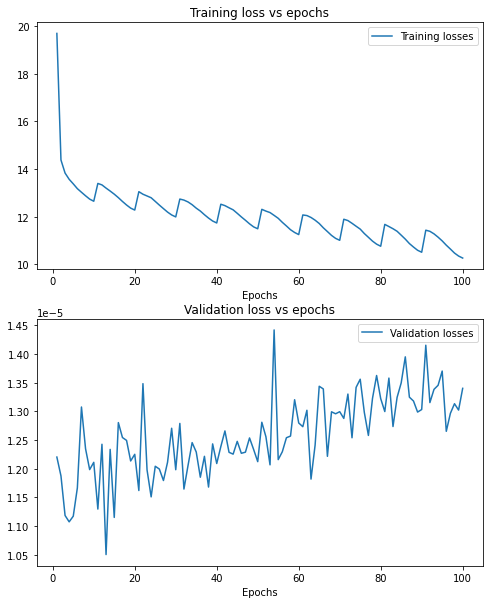

In [ ]:
# fig, (axe1, axe2) = plt.subplots(2)
fig = plt.figure(figsize=(8, 10), facecolor=(1, 1, 1))

axe1 = fig.add_subplot(2, 1, 1)
axe1.plot(range(1, epochs + 1), training_loss_list, label='Training losses')
axe1.set_title('Training loss vs epochs')
axe1.set_xlabel('Epochs')
plt.legend()


axe2 = fig.add_subplot(2, 1, 2)
axe2.plot(range(1, epochs + 1), val_loss_list, label='Validation losses')
axe2.set_title('Validation loss vs epochs')
axe2.set_xlabel('Epochs')
plt.legend()

fig.savefig('model'+ model_args['model_num'] + '_loss.png')

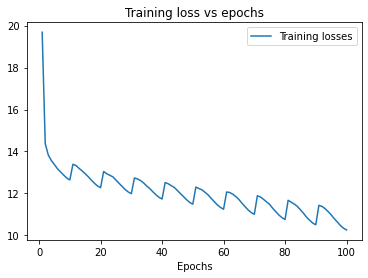

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('Training loss vs epochs')
plt.plot(range(1, epochs + 1), training_loss_list, label='Training losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_training_loss.png', dpi=300)

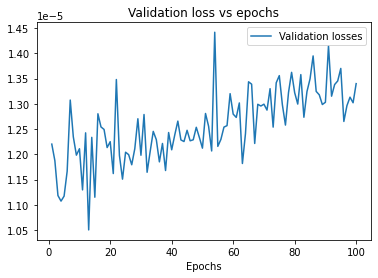

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('Validation loss vs epochs')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_validation_loss.png', dpi=300)

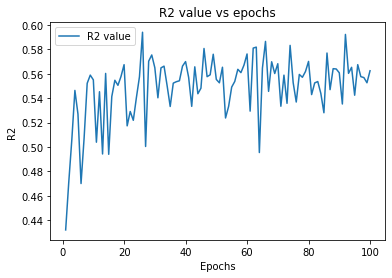

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('R2 value vs epochs')
plt.plot(range(1, epochs + 1), r2_list, label='R2 value')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_r2.png', dpi=300)